In [3]:
import numpy as mp

## Parameters calibration with exogenous variables.

An essential step is the calibration of $alpha$ and $beta$, i.e. find the *optimal* parameters that maximise our correlation between model and actual. 

We decide to perform just a **grid search**, defining a way to compare our list rankings using the Spearman method from `scipy.stats`. So, we define a landscape, $[-2,2] \times [-2,2]$ with resolution $50 \times 50$ for istance, and evaluate at all those points (using the analytic method). Finally we will return the top correlation we found.

NB: also for this step, we take inspiration by the work by Klein, Maillart, and Chuang.

In [12]:
def rank_comparison(a_ranks_sorted, b_ranks_sorted, do_plot=False):
    a_list = list()
    b_list = list()
    for atup in a_ranks_sorted:
        aiden = atup[0]
        apos = atup[1]
        #find this in our other list
        for btup in b_ranks_sorted:
            biden = btup[0]
            bpos = btup[1]
            if aiden == biden:
                a_list.append(apos)
                b_list.append(bpos)
    if do_plot:    
        plt.figure(figsize=(10,20))
        plot([1,2], [a_list, b_list], '-o')
        plt.show()
    
    return ss.spearmanr(a_list, b_list)

def calibrate_analytic(M, ua, exogenous_ranks_sorted, user_or_art_dict, index_function, title, do_plot=False):
    
    if ua == 'users':
        w_star_type = 'w_star_c'
    elif ua == 'articles':
        w_star_type = 'w_star_p'
    
    squarelen = range(0,50)
    
    alpha_range = map(index_function,squarelen)
    beta_range = map(index_function,squarelen)
    landscape = np.zeros(shape=(len(list(alpha_range)),len(list(beta_range))))

    top_spearman = {'spearman':None,'alpha':None, 'beta':None, 'ua':ua}

    for alpha_index, alpha in enumerate(alpha_range):
        for beta_index, beta in enumerate(beta_range):
            
            w_converged = w_star_analytic(M, alpha, beta, w_star_type)
            
            w_ranks = {name: w_converged[pos] for name, pos in user_or_art_dict.iteritems() }
            w_ranks_sorted = sorted(w_ranks.iteritems(), key=operator.itemgetter(1))
            
            spearman = rank_comparison(w_ranks_sorted, exogenous_ranks_sorted)

            if spearman[1] < 0.05:
                landscape[alpha_index][beta_index] = spearman[0]
                
                if (not top_spearman['spearman']) or (spearman[0] > top_spearman['spearman']):
                    top_spearman['spearman'] = spearman[0]
                    top_spearman['alpha'] = alpha
                    top_spearman['beta'] = beta
            else:
                landscape[alpha_index][beta_index] = np.nan

    if do_plot:
        plt.figure(figsize=(10,10))
        heatmap = imshow(landscape, interpolation='nearest', vmin=-1, vmax=1)
        #heatmap = plt.pcolor(landscape)
        colorbar = plt.colorbar(heatmap)
        plt.xlabel(r'$ \beta $')
        plt.xticks(squarelen, beta_range, rotation=90)
        plt.ylabel(r'$ \alpha $')
        plt.yticks(squarelen, alpha_range)
        plt.title(title)
        
        landscape_file = open(title+'_landscape.npy', 'w')
        np.save(landscape_file, landscape)
        plt.savefig(title+'_landscape.eps')

    return top_spearman

Ok, now let's run the calibration and get our optimising variables.

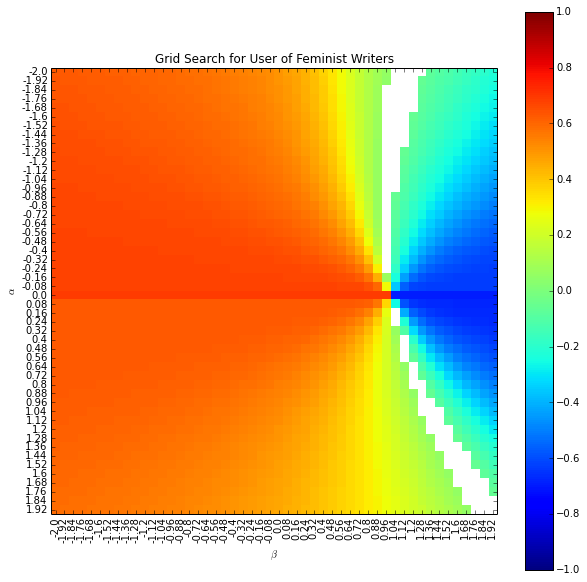

In [13]:
user_spearman = calibrate_analytic(M=make_bin_matrix(feminist_data['M']),
                                   ua='users',
                                   exogenous_ranks_sorted=feminist_data['user_exogenous_ranks'],
                                   user_or_art_dict=feminist_data['user_dict'],
                                   index_function=lambda x: (x-25)/12.5, 
                                   title='Grid Search for User of Feminist Writers',
                                   do_plot=True)

Note that the white parts of the gridsearch are where the Spearman rho value was not significant using 0.05 as a threshold.

In [14]:
print('Optimizing points from gridsearch', 
      'rho:', user_spearman['spearman'], 
      'alpha', user_spearman['alpha'], 
      'beta', user_spearman['beta'] )

('Optimizing points from gridsearch', 'rho:', 0.6923148495709821, 'alpha', 0.0, 'beta', -2.0)
